<hr>
<h1 style="text-align: center;">Source Panel Method</h1>
<hr>

<h3 style="text-align: center;">Nicholas Richmond</h3>
<h3 style="text-align: center;">Student ID: 919578115</h3>
<h3 style="text-align: center;">Project #: 3</h3>
<h3 style="text-align: center;">Date: 11/8/24</h3>

<h3 style="text-align: center;">EAE 127: Applied Aerodynamics</h3>
<h3 style="text-align: center;">University of California, Davis</h3>

<hr>

In [12]:
#standard imports and setups
import pandas as pd #type: ignore
import numpy as np #type: ignore
import os
import sys
import matplotlib.pyplot as plt #type: ignore
import matplotlib.lines as mlines
import math
from scipy import integrate
### JUPYTER NOTEBOOK SETTINGS ########################################
#Plot all figures in full-size cells, no scroll bars
%matplotlib inline
#Disable Python Warning Output
#(NOTE: Only for production, comment out for debugging)
import warnings
warnings.filterwarnings('ignore')
### PLOTTING DEFAULTS BOILERPLATE (OPTIONAL) #########################
#SET DEFAULT FIGURE APPERANCE
import seaborn as sns #Fancy plotting package #type: ignore
#No Background fill, legend font scale, frame on legend
sns.set_theme(style='whitegrid', font_scale=1.5, rc={'legend.frameon': True})
#Mark ticks with border on all four sides (overrides 'whitegrid')
sns.set_style('ticks')
#ticks point in
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
#fix invisible marker bug
sns.set_context(rc={'lines.markeredgewidth': 0.1})
#restore default matplotlib colormap
mplcolors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
'#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
sns.set_palette(mplcolors)

#Get color cycle for manual colors
colors = sns.color_palette()
#SET MATPLOTLIB DEFAULTS
#(call after seaborn, which changes some defaults)
params = {
#FONT SIZES
'axes.labelsize' : 30, #Axis Labels
'axes.titlesize' : 30, #Title
'font.size' : 28, #Textbox
'xtick.labelsize': 22, #Axis tick labels
'ytick.labelsize': 22, #Axis tick labels
'legend.fontsize': 15, #Legend font size
'font.family' : 'serif',
'font.fantasy' : 'xkcd',
'font.sans-serif': 'Helvetica',
'font.monospace' : 'Courier',
#AXIS PROPERTIES
'axes.titlepad' : 2*6.0, #title spacing from axis
'axes.grid' : True, #grid on plot
'figure.figsize' : (8,8), #square plots
'savefig.bbox' : 'tight', #reduce whitespace in saved figures
#LEGEND PROPERTIES
'legend.framealpha' : 0.5,
'legend.fancybox' : True,
'legend.frameon' : True,
'legend.numpoints' : 1,
'legend.scatterpoints' : 1,
'legend.borderpad' : 0.1,
'legend.borderaxespad' : 0.1,
'legend.handletextpad' : 0.2,
'legend.handlelength' : 1.0,
'legend.labelspacing' : 0,
}
import matplotlib #type:ignore
matplotlib.rcParams.update(params) #update matplotlib defaults, call after￿
### END OF BOILERPLATE ##################################################
colors = sns.color_palette() #color cycle

## Problem 1: Source Panel Method

This problem is an introduction to how the panel method works, and involves setting up a few things in python. Namely, the class `Panel` and the functions `integral_normal()` and `integral_tangential()`.


In [2]:
class Panel:
    """
    Here, we are creating a panel object and all its necessary information. 
    """

    def __init__(self, xa, ya, xb, yb):
        """
        Initialization of the panel.

        Here, we write a specific piece of code to be run everytime we create a panel object. In a general sense, the "init" command/function
        will be run every time that we create a new panel.

        Our code needs to calculate the center point of the panel, the length, and its angle.

        Our code also needs to make space for the source strength, tangential velocity, and pressure coefficient
        (which we will define for a specific panel later)
        
        Parameters:
        -----------
        xa: float
            x - coordinate of the first end point
        ya: float
            y - coordinate of the first end point
        xb: float
            x - coordinate of the second end point
        yb: float
            y - coordinate of the second end point
        xc: float
            x - coordinate of the center point of the panel
        yc: float
            y - coordinate of the center point of the panel 
        length: float
            length of the panel
        beta: float
            orientation/angle of the panel

        These parameters are not defined until later. We set them equal to zero below. 
        sigma: float
            source sheet strength
        vt: float
            velocity tangential to the panel
        cp: float
            pressure coefficient


        """

        self.xa, self.ya = xa, ya           # Defines the first end point
        self.xb, self.yb = xb, yb           # Defines the second end point

        # Defining center point and panel parameters
        # You will need to define these yourself:
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2         # Control point or center point (How do you find the center of two points?)
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)    # Length of the panel (How do you find the distance between two points)

        # For the orientation of the panel (angle between x axis and the unit vector normal to the panel)
        if xb - xa <= 0:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)

        # Location of the panel (we will use this later when we expand our analys to airfoils)
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'

        # Will need a value for theta
    
        self.theta = math.atan2(self.yc, self.xc)

        if self.theta < 0:
            self.theta += 2*np.pi
        # We also need 3 more parameters, sigma, vt for tangential velocity, and cp for pressure distribution. 
        # Create these and set the equal to zero for now
        

        self.sigma = 0.0 
        self.vt = 0.0
        self.cp = 0.0

def integral_normal(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.

    Parameters:
    -----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated. 
    """

    def integrand(s):
        return (((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.cos(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.sin(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

def integral_tangential(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the tangential direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """

    # You will need to write in the tangetial velocity equation below. 
    # Remember that we only need the terms within the integrand, and we can leave
    # the freestream velocity (U infinity) term for later.
    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]


**Panel Class:**

The Panel class is an object created to help define different panels. Each new panel that we define in the future will have a few attributes that are gathered from the x and y coordinates of each end of the panel. Things like the angle between the normal of the panel and the x-axis, whether the panel is on the upper or lower surface of the airfoil and the length all are designated as properties of the panel, which can be called with syntax in the form of `Panel.attribute_of_interest`.  

The Panel class takes in the coordinates of both ends of the desired panel. Using trigonometry, all other aspects and metrics about the panel can be derived and assigned.

The panel method is useful to us for aerodynamics analysis because it allows us to quickly create and model many panels, each with their own unique attirbutes. The ability to create any number of panels and to keep track of them in an organized and systematic way is why creating an object for panels is a good choice.

**Normal Integral Fuction:**

The purpose of the normal integral function is to determine the contribution of any source panel on the center point of any other source panel, in the normal direction. It takes in the two panels in question, and finds the contribution of first panel at the center point of the second panel, and returns that contribution. It uses the locations of the center points and the beta angles of the panels using the `Panel` class.

**Tangential Integral Function**

The purpose of the tangential integral function is very similar to that of the normal integral function. The only difference is the direction of the contribution. In the normal integral function, the contribution is found in the normal direction; in the tangential integral function, the contribution is found in the tangential direction.

<hr>

## Problem 2: Flow Over a Non-Rotating Cylinder

This problem asks us to analyzed the flow over a nonrotating cylinder using the panel discretization method using different numbers of panels.


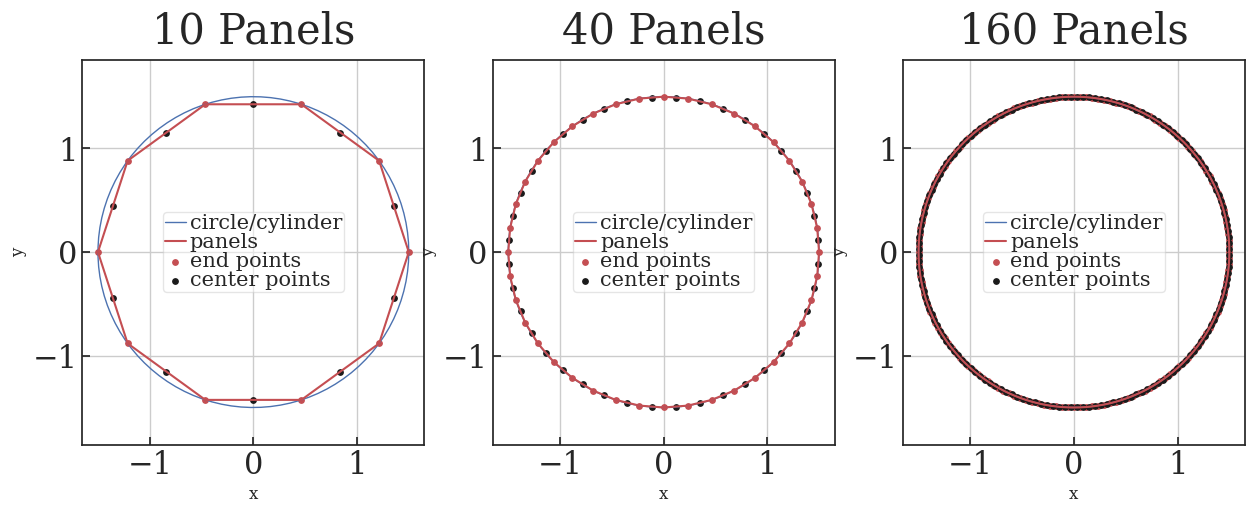

In [3]:
#create the geometry of the circle and the x-y coordinates of the panels
N_panels = 6             # We are going to use 6 panels in this quick test to see how our panel function/object works


R = 1.5
x_circle = R * np.cos(np.linspace(0.0, 2 * math.pi, 100))
y_circle = R * np.sin(np.linspace(0.0, 2 * math.pi, 100))

#function to generate any number of panels and their coordinates
def discretizeCylinder(numPanels):

    x_points = R * np.cos(np.linspace(0.0, 2 * math.pi, numPanels + 1))
    y_points = R * np.sin(np.linspace(0.0, 2 * math.pi, numPanels + 1))
    # Here we just create some information that describes a circle, but we will also use these points
    # to describe our panel end points. 

    cylinder_panels = np.empty(numPanels, dtype = object)     
    # The line above creates an array called cylinder_panels, and designates that the type of data we are going to store in this array are objects.
    # In other words we will use this array to store all of the panel objects we are about to create. 

    # Here is where we will do something new, using our Panel code we created above:
    for i in range(numPanels):
        cylinder_panels[i] = Panel(x_points[i], y_points[i], x_points[i+1], y_points[i+1])
    
    return x_points, y_points, cylinder_panels

def plotPaneledCircle(cylinder_panels):
    
    plt.grid()
    plt.xlabel('x', fontsize = 12)
    plt.ylabel('y', fontsize = 12)

    plt.plot(x_circle, y_circle, label = 'circle/cylinder', color = 'b', linewidth = 1)
    # Plotting our circle/the geometry we would like to discretize

    plt.plot(x_points, y_points, label = 'panels', color = 'r')
    # Plotting our end points / panels
    # Here, we are plotting the exact same points that we provided to our Panel function. 
    # Remember that we are using these as the end points of our panels

    plt.scatter([p.xa for p in cylinder_panels], [p.ya for p in cylinder_panels], label = 'end points', color = 'r', s = 15)
    # This code may look a little bit odd to you. The code within the brackets accesses the information 
    # inside of the variable 'cylinder_panels'. For each panel inside of 'cylinder_panels', we plot 
    # the xa and ya variables associated with those panels.

    plt.scatter([p.xc for p in cylinder_panels], [p.yc for p in cylinder_panels], label = 'center points', color = 'k', s = 15)
    # The same is done here as above, except we use the center points instead of the end points.
    # Using the code here we can access any of the information within a specific Panel object. 
    plt.axis("equal")
    plt.legend(loc = 'best')


plt.figure(figsize=(15,5))
x_points, y_points, cylinder_panels = discretizeCylinder(10)
plt.subplot(1,3,1)
plt.grid()
plt.title("10 Panels")
plotPaneledCircle(cylinder_panels)

x_points, y_points, cylinder_panels = discretizeCylinder(40)
plt.subplot(1,3,2)
plt.grid()
plt.title("40 Panels")
plotPaneledCircle(cylinder_panels)

plt.subplot(1,3,3)
plt.grid()
plt.title("160 Panels")
x_points, y_points, cylinder_panels = discretizeCylinder(160)
plotPaneledCircle(cylinder_panels)
plt.show()


These three plots show how more panels can create a better approximation of a circle using flat elements. Even at just 40 elements, the approximation to a cylinder is very good. 

In the next section we will analyze each of these cases to determine the strength of each panel and confirm if each distribution creates a closed body.

Panel Analysis for 160 Panels Complete!
Sum of sources and sinks:
10 Panel Cylinder: 0
40 Panel Cylinder: 8.8818e-15
160 Panel Cylinder: 1.1102e-14


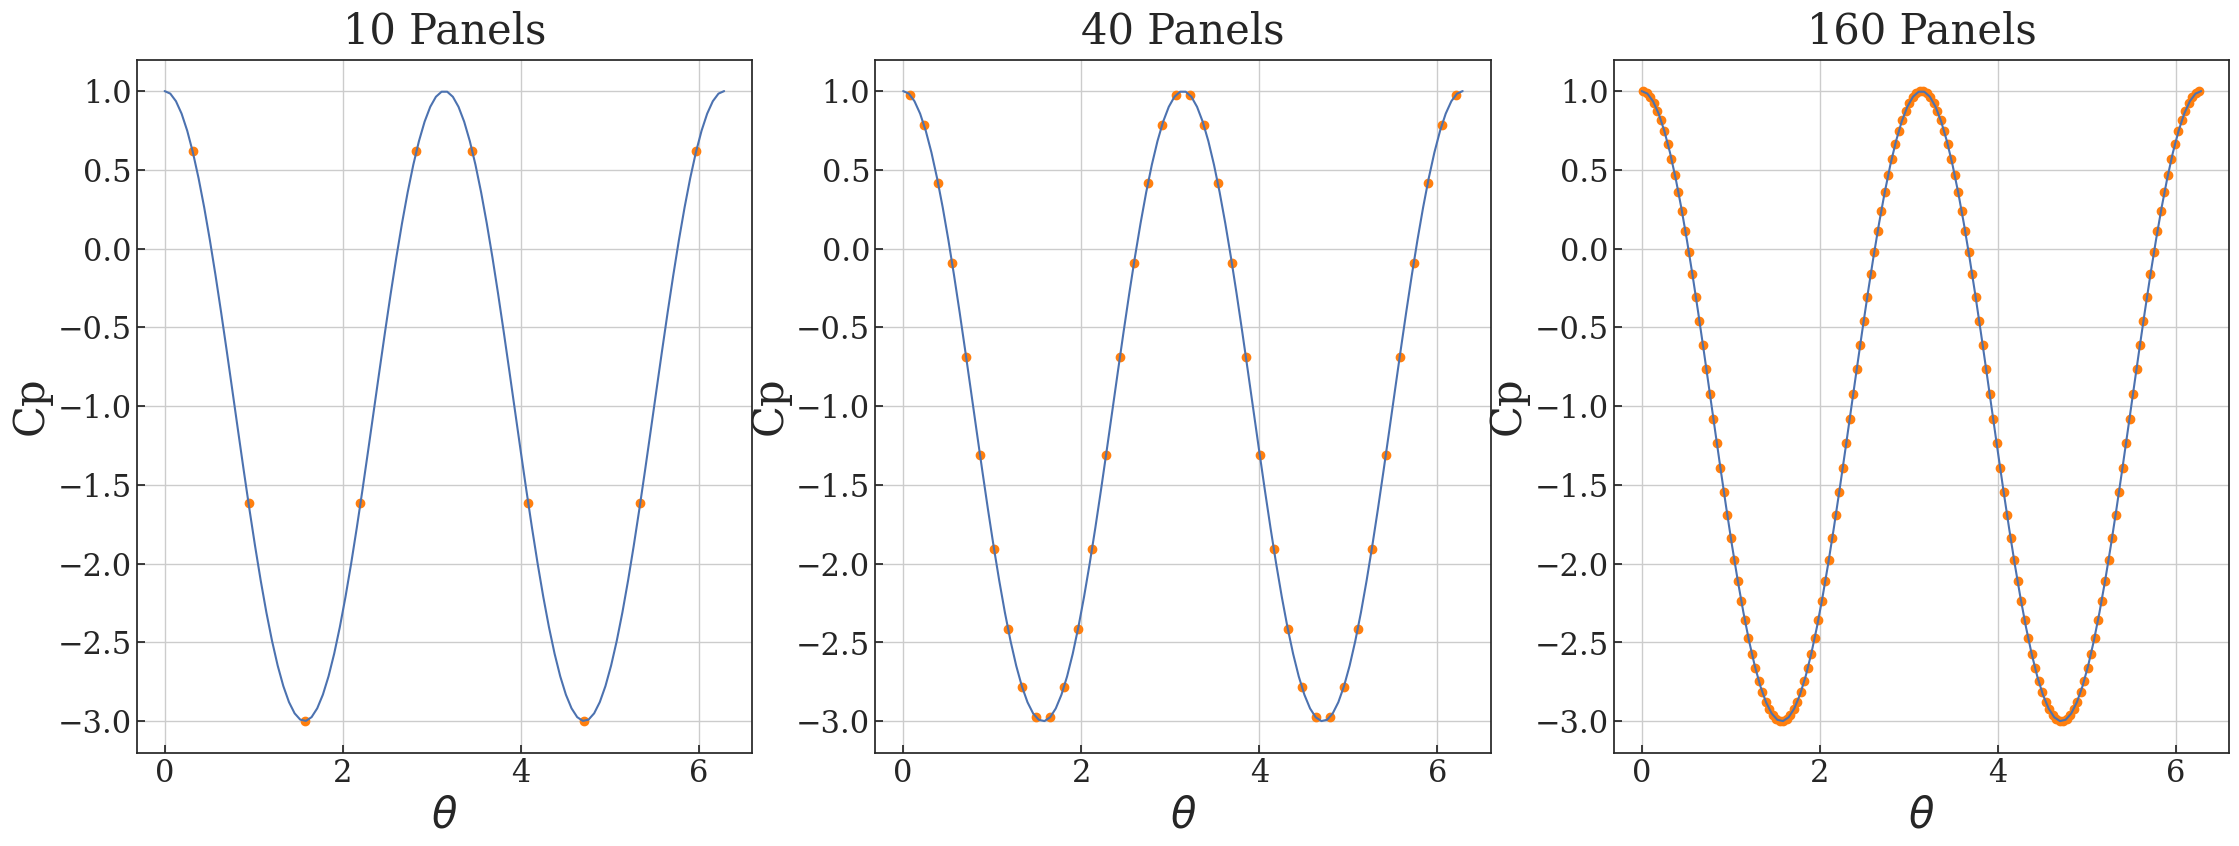

In [11]:
#Analyze different discretizations of a cylinder using the panel method
#adds other important information about each panel to each panel class.
def analyze_panels(panels, u_inf):
    """"
    Here, we write some code to analyze our panels after they have been created. 

    Creates a source influence matrix [A]


    Input: an array of panels created using the Panel function (panels) and a freestream velocity (u_inf). 

    """

    Num = len(panels)

    # First we need the Normal Velocity Calculations

    A_n = np.empty((Num, Num), dtype = float)
    np.fill_diagonal(A_n, 0.5)
        # Whenever we have i = j, we have sigma(i)/2 or sigma(i)*0.5. Thus, on our diagonal for matrix A we should have 0.5 
        # The diagonal of a matrix means i = j i.e (1,1), (2,2), etc etc.

    # Create the source influence matrix [A] of the linear system
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A_n[i,j] = (0.5/math.pi) * integral_normal(p_i, p_j)

    # Create the right hand side [b] of the linear system
    b_n = - u_inf * np.cos([p.beta for p in panels])

    sigma = np.linalg.solve(A_n,b_n)

    for i, panel in enumerate(panels):
        panel.sigma = sigma[i]

    # ====================================================================== #
    # Now we need the Tangential Velocity Calculations
    A_t = np.empty((Num, Num), dtype = float)
    np.fill_diagonal(A_t, 0.0)

    # Create the source influence matrix [A] of the linear system
    # STUDENTS WILL FILL THIS IN DELETE LATER
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i!=j:
                A_t[i,j] = (0.5 / math.pi) * integral_tangential(p_i, p_j)

    # Create the right hand side [b] of the linear system
    # STUDENTS ALSO FILL THIS IN
    b_t = -u_inf * np.sin([p.beta for p in panels])

    # Finally, we compute the tangential velocity:
    # STUDENTS ALSO FILL THIS IN
    vt = np.dot(A_t, sigma) + b_t

    for i, panel in enumerate(panels):
        panel.vt = vt[i]
    
    # STUDENTS FILL THIS IN
    # Finally, lets use our tangential velocity to calculate surface pressure Cp:

    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/u_inf)**2

    print('Panel Analysis for {} Panels Complete!'.format(Num),end="\r")


u_inf = 10
x_points10, y_points10, cylinder_panels10 = discretizeCylinder(10)
analyze_panels(cylinder_panels10, u_inf)
sumSource10 = 0
for panel in cylinder_panels10:
    sumSource10 += panel.sigma*panel.length

x_points40, y_points40, cylinder_panels40 = discretizeCylinder(40)
analyze_panels(cylinder_panels40, u_inf)
sumSource40 = 0
for panel in cylinder_panels40:
    sumSource40 += panel.sigma*panel.length

x_points160, y_points160, cylinder_panels160 = discretizeCylinder(160)
analyze_panels(cylinder_panels160, u_inf)
sumSource160 = 0

for panel in cylinder_panels160:
    sumSource160 += panel.sigma*panel.length
print("\nSum of sources and sinks:\n10 Panel Cylinder: {:.5g}\n40 Panel Cylinder: {:.5g}\n160 Panel Cylinder: {:.5g}".format(sumSource10,sumSource40,sumSource160))
#print(sumSource10, sumSource40, sumSource160)
cp_analytical = 1.0 - 4 * (y_circle / R)**2
length = (len(x_circle))
theta = np.zeros((length))

for i in range(0, length):
    theta[i] = math.atan2(y_circle[i], x_circle[i])
    if theta[i] < 0:
        theta[i] += 2*np.pi

plt.figure(figsize=(27,9))
plt.subplot(1,3,1)
plt.scatter([panel.theta for panel in cylinder_panels10],[panel.cp for panel in cylinder_panels10],label = "Coefficients of Pressure",color = colors[1]);
plt.plot(theta, cp_analytical,label='analytical',color='b', linestyle='-', linewidth=1.5, zorder=1);
plt.title("10 Panels")
plt.xlabel(r"$\theta$")
plt.ylabel("Cp")

plt.subplot(1,3,2)
plt.scatter([panel.theta for panel in cylinder_panels40],[panel.cp for panel in cylinder_panels40],label = "Coefficients of Pressure",color = colors[1]);
plt.plot(theta, cp_analytical,label='analytical',color='b', linestyle='-', linewidth=1.5, zorder=1);
plt.title("40 Panels")
plt.xlabel(r"$\theta$")
plt.ylabel("Cp")

plt.subplot(1,3,3)
plt.scatter([panel.theta for panel in cylinder_panels160],[panel.cp for panel in cylinder_panels160],label = "Coefficients of Pressure",color = colors[1]);
plt.plot(theta, cp_analytical,label='analytical',color='b', linestyle='-', linewidth=1.5, zorder=1);
plt.title("160 Panels")
plt.xlabel(r"$\theta$")
plt.ylabel("Cp");

The strengths cancel out in accordance with Anderson 3.157. Interestingly, when summing the strengths of the panels, if an array of each strength was first created (using `np.append()`), there were increasingly large precision errors with panel counts above 127. While I did not try to test it too much, it seems like there is a large floating point innacuracy within `np.append` and I am not sure why.

The next step is to quantify the errors of each method by finding the difference in the integrated areas of both curves at various panel counts.

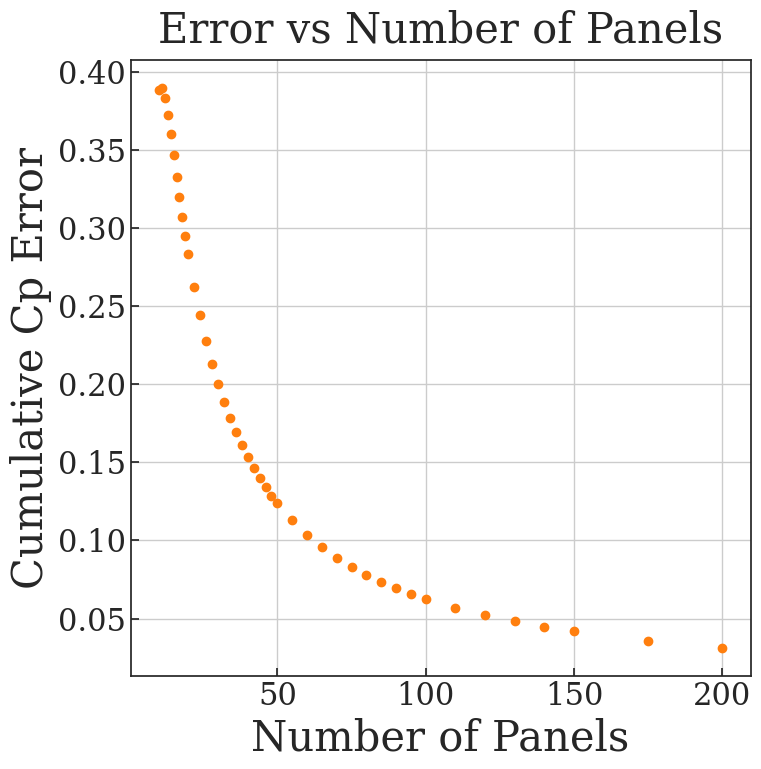

In [5]:
#Find the error of the panel method's cp vs the analytical cylinder cp

def getError(numPanels):
    x_points, y_points, cylinder_panels = discretizeCylinder(numPanels)
    analyze_panels(cylinder_panels, u_inf)

    error = np.trapz(cp_analytical,theta) - np.trapz([p.cp for p in cylinder_panels],[p.theta for p in cylinder_panels])
    return abs(error)

plt.figure()
i = 10
while i < 201:
    error = getError(i)
    plt.plot(i,error, marker = 'o',linestyle = '-',linewidth = 1,color = colors[1])
    if i < 20:
        i += 1
    elif i < 50:
        i += 2
    elif i < 100:
        i += 5
    elif i < 150:
        i += 10
    elif i < 200:
        i += 25
    elif i < 300:
        i += 50
    else:
        i += 100

plt.title("Error vs Number of Panels")
plt.xlabel("Number of Panels")
plt.ylabel("Cumulative Cp Error")
plt.show()


This plot displays the absolute value of the error between the cumulative Cp of various panel approximations and the cumulative analytical Cp of the cylinder. There is a very clear trend of decreasing error as the number of panels increases. This value approaches zero as the number of panels increases, but never actually reaches it. Also, for large panel numbers, the amount of time it took to analyze each new cylinder discretization increased drastically (probably exponentially). Thus, there is a certain discretization that is the most efficient in terms of time taken to run and acceptable error.

<hr>

## Problem 3: Symmetric and Cambered Airfoil Panel Methods 



['/opt/homebrew/Cellar/python@3.12/3.12.7_1/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.7_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.7_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/ndrichmond/VSCode/EAE127/.venv/lib/python3.12/site-packages']
